# Practical work 07 - Classification with Support Vector Machines (SVM)
by Aurélien Héritier and Jean Nanchen

## Exercice 1 - Digit classification system using different SVM classifiers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from collections import Counter

from sklearn.utils import resample

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import confusion_matrix

### a. Getting the training and test sample sets from the MNIST database

Load MNIST digit dataset - see previous PW

In [23]:
# This is a method to read the MNIST dataset from a ROOT directory
def load_MNIST(ROOT):
  '''load all of mnist
  training set first'''
  Xtr = []
  train = pd.read_csv(os.path.join(ROOT, 'mnist_train.csv'))
  X = np.array(train.drop('label', axis=1))
  Ytr = np.array(train['label'])
  # With this for-loop we give the data a shape of the acctual image (28x28)
  # instead of the shape in file (1x784)
  for row in X:
      Xtr.append(row.reshape(28,28))
  # load test set second
  Xte = []
  test = pd.read_csv(os.path.join(ROOT, 'mnist_test.csv'))
  X = np.array(test.drop('label', axis=1))
  Yte = np.array(test['label'])
  # same reshaping
  for row in X:
      Xte.append(row.reshape(28,28))
  
  return np.array(Xtr), np.array(Ytr), np.array(Xte), np.array(Yte)


mnist_dir = 'mnist'
train_X, train_y, test_X, test_y = load_MNIST(mnist_dir)

In [24]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


Visualize (plot) the images of some digits of the MNIST database. You should get something similar to Figure 1.

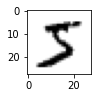

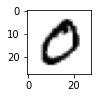

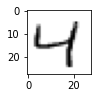

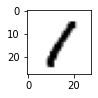

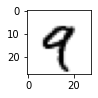

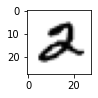

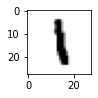

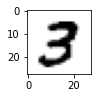

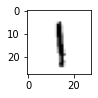

In [25]:
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('binary'))
    plt.show()

Build the final training and test sets, which should be balanced, i.e. have the same
number of samples per class (i.e. digit), for example 200 per class for training, and 100
for test.

In [26]:
print(f"balance train_y : {Counter(train_y)}")
print(f"balance test_y : {Counter(test_y)}")

sample_train = 500
sample_test = 200

#X_imbalanced = np.vstack((X[y == 0][:30], X[y == 1][:30]))
# train_y = np.hstack((train_y[train_y == 0][:sample_train], train_y[train_y == 1][:sample_train], train_y[train_y == 2][:sample_train], train_y[train_y == 3][:sample_train], train_y[train_y == 4][:sample_train]))

# Separate majority and minority classes


def resample_set(X, y, nb_sample):
    
    y_result = np.empty(0)
    
    df = pd.DataFrame(X)
    #y_combined = np.r_[y_train, y_test]
    print(df.head)
    
    for i in range(10):
        
        classe = df[y==i]
        y_downsampled = resample(classe, 
                             replace=False,    # sample without replacement
                             n_samples=nb_sample,     # to match minority class
                             random_state=123) # reproducible results
        #print(downsampled)
        y_result = np.concatenate((y_result, y_downsampled))

    #print(y_downsampled)
        
        #y_downsampled
    # Downsample majority class
   
 
# Combine minority class with downsampled majority class
#df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
#df_downsampled.balance.value_counts()


#resample_set(train_X, train_y, sample_train)
#resample_set(test_X, test_y, sample_test)

train_y_full = train_y
train_X_full = train_X
test_y_full = test_y
test_X_full = test_X

train_y = train_y[:sample_train*10]
train_X = train_X[:sample_train*10]
test_y = test_y[:sample_test*10]
test_X = test_X[:sample_test*10]



print(f"balance train_y : {Counter(train_y)}")
print(f"balance test_y : {Counter(test_y)}")

balance train_y : Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
balance test_y : Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})
balance train_y : Counter({1: 563, 7: 550, 4: 535, 6: 501, 9: 495, 3: 493, 2: 488, 0: 479, 8: 462, 5: 434})
balance test_y : Counter({1: 234, 2: 219, 4: 217, 3: 207, 7: 205, 9: 194, 8: 192, 5: 179, 6: 178, 0: 175})


Balance is not working, but we reduce the dataset to reduce compute time. The dataset is not so much unbalanced, so it will not have a significant impact.

## b. Classification of digits based on raw pixel values using SVM and different
kernels
Create, train and test several SVM classifiers with different kernels (linear, polynomial, RBF,...).
For the training, perform a cross-validation using 10 folds, and test different with several C and
kernel parameter values (e.g. for γ for RBF kernel) in order to get the best classifier. After the
test, display the classification performances and confusion matrix of each SVM classifier (see
class metrics).

### SVM

In [27]:
# flatten the images
X_test_flatten = test_X.reshape((len(test_X), -1))
X_train_flatten = train_X.reshape((len(train_X), -1))

print(Counter(train_y))

Counter({1: 563, 7: 550, 4: 535, 6: 501, 9: 495, 3: 493, 2: 488, 0: 479, 8: 462, 5: 434})


In [28]:
# for each kernel
def analyse_svm(X_train_flatten, train_y, X_test_flatten, kernel):

    param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': [kernel]}

    #clf = svm.SVC(kernel='linear', C=1.0, gamma=0.001)
    grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2,cv = 10) # 10-fold
    # Learn the digits on the train subset
    #clf.fit(X_train_flatten, train_y)
    grid.fit(X_train_flatten,train_y)
    
    print(f"Test with kernel {kernel}")

    print(grid.best_estimator_)

    # Predict the value of the digit on the test subset
    #predicted = clf.predict(X_test_flatten)
    predicted = grid.predict(X_test_flatten)

    print("accuracy score:", metrics.accuracy_score(test_y, predicted))
    
    print(
        f"Classification report for classifier {grid}:\n"
        f"{metrics.classification_report(test_y, predicted)}\n"
    )

    cm = confusion_matrix(test_y, predicted)
    print("confusion matrix :")
    print(cm)
    
    print("-----------------------------")
    print()

In [8]:
analyse_svm(X_train_flatten, train_y, X_test_flatten, 'linear')
analyse_svm(X_train_flatten, train_y, X_test_flatten, 'poly')
analyse_svm(X_train_flatten, train_y, X_test_flatten, 'rbf')
analyse_svm(X_train_flatten, train_y, X_test_flatten, 'sigmoid')




Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.8s
[CV] END ....................C=0.1, gamma=0.1,

C:\Users\marda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   6.4s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   6.6s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   6.4s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   6.5s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   6.5s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   6.4s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   6.6s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   6.4s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   6.7s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   6.7s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   6.5s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   6.7s
[CV] END ...................

C:\Users\marda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# best case with full dataset

# flatten the images
X_test_flatten_full = test_X_full.reshape((len(test_X_full), -1))
X_train_flatten_full = train_X_full.reshape((len(train_X_full), -1))

clf = svm.SVC(kernel='poly', C=0.1, gamma=1)

clf.fit(X_train_flatten_full, train_y_full)

predicted_full = clf.predict(X_test_flatten_full)

print("accuracy score:", metrics.accuracy_score(test_y_full, predicted_full))
    
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(test_y_full, predicted_full)}\n"
)

cm = confusion_matrix(test_y_full, predicted_full)
print("confusion matrix :")
print(cm)

accuracy score: 0.9787
Classification report for classifier SVC(C=0.1, gamma=1, kernel='poly'):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


confusion matrix :
[[ 972    0    1    1    0    3    1    0    2    0]
 [   0 1126    2    1    1    0    3    0    2    0]
 [   8    0 1006   

## d. Analysis of the results

Analyse the results obtained with the best SVM classifier.
a) Which kernel and parameters were used ?

SVC(C=0.1, gamma=1, kernel='poly') with accuracy score: 0.921

b) Which digit classes are the best/worse recognized against which ? Why ?

We don't see a significant difference between digits. Maybe it's because the dataset is a bit unbalanced (balance step is not working !). There is more 1 and 7. The 2 harder digits to recognize.

c) What is the impact of the sizes of the training and test sets on the classification performance ?

With only 2000 sample on the train set => 0.912
With all the dataset => 0.9787

the size of the dataset impact the performance !

# Exercice 2 - Review questions

a) What are the two fundamental ideas a SVM are built on ? Summarize them with your own words.

SVM means support vector machine. The objective of this algorithm is to find a hyperplace in an n-dimensional space that classifies the data points.

b) With the hinge loss, training points can fall into three cases. Re-explain these cases with your own words.

There is 3 category :
* It can be on the good side and out of the margin ==> no penality, loss == 0
* It can be on the wrong side and it give a penalty increasing with the distance to the border ==> minimum loss is 1.0
* It can be on the good side, but in the margin ==> small penality, 0 if its on the margin and 1 if its in the border

c) What are the two implementations of SVMs available in SciKit Learn ? Which one would you take if you have a system that needs to incorporate incremental learning ?

libsvm & liblinear; for lots of datas, libsvm is very slow so its better to use liblinear

d) A SVM can classify between 2 classes. Cite and explain in your own words the 2 strategies we have to build a multi-class (with K classes) system with SVM ?

Two strategy : one vs all & one vs one
* one vs all will merge the other class and classify one class versus the others class
* one vs one will erase other class and leave only two class, and it will classify for the two class. And it will proceed like this for all class

Look ath the image here : https://towardsdatascience.com/multi-class-classification-one-vs-all-one-vs-one-94daed32a87b

e) Are the strategies of point d) equal in terms of cpu ? (elaborate your answer considering training and testing times)

* one vs all ==> less computation, more sensible to unbalanced dataset
* one vs one ==> more compute, less sensible to unbalanced dataset

f) Describe a machine learning task for which SVM would be a better choice than any of
the algorithms previously studied. Explain why.

to classify or detect an anomaly

Fast implementing, work good when we have no idea on the data